# Contemporaneous WV in-track stereo and Airborne LiDAR
David Shean  
2/27/23

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import fiona
import contextily as ctx

In [3]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
ak_state = states_gdf.loc[states_gdf['NAME'] == 'Alaska']
ak_geom = ak_state.iloc[0].geometry

In [37]:
#wesm_url = 'http://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/metadata/WESM.gpkg'

In [38]:
topdir = '/Users/dshean/scr/STV_stereo_lidar_analysis'

In [39]:
wesm_fn = os.path.join(topdir, 'WESM.gpkg')

In [42]:
maxar_gdb_fn = os.path.join(topdir, 'dg_archive_20230222.gdb.zip')
maxar_gdb_stereo_layer = fiona.listlayers(maxar_gdb_fn)[0]

In [91]:
maxar_fn_all = os.path.join(topdir, 'dg_archive_20230222_dg_imagery_index_stereo_CC25.gpkg')
maxar_fn_conus = os.path.join(topdir, 'dg_archive_20230222_dg_imagery_index_stereo_CONUS_CC25.gpkg')

## Load G-LiHT index AK
* https://glihtdata.gsfc.nasa.gov/

In [69]:
gliht_ak_fn = os.path.join(topdir, 'gliht_alaska.zip')

In [71]:
gliht_ak = gpd.read_file('/vsizip/'+gliht_ak_fn)

<AxesSubplot:>

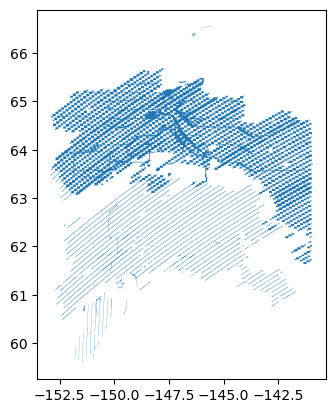

In [72]:
gliht_ak.plot()

In [84]:
gliht_ak['datetime'] = pd.to_datetime(gliht_ak['file'].str.split('_', expand=True)[1])

In [92]:
gliht_ak

,Name,Descriptio,file,geometry,datetime
0,l0s569,None,AK_10Jul2014_tiles,"POLYGON ((-141.35262 61.67427, -141.20982 61.6...",2014-07-10
1,l0s570,None,AK_10Jul2014_tiles,"POLYGON ((-141.21501 61.71124, -141.06898 61.7...",2014-07-10
2,l0s571,None,AK_10Jul2014_tiles,"POLYGON ((-141.07530 61.73640, -140.97208 61.7...",2014-07-10
3,l10s614,None,AK_10Jul2014_tiles,"POLYGON ((-141.01062 62.39271, -140.97238 62.3...",2014-07-10
4,l10s615,None,AK_10Jul2014_tiles,"POLYGON ((-141.15026 62.38355, -141.00497 62.3...",2014-07-10
...,...,...,...,...,...
13473,l9s629,None,Kenai_19Aug2014_tiles,"POLYGON ((-151.43434 59.96534, -151.42519 59.9...",2014-08-19
13474,l9s630,None,Kenai_19Aug2014_tiles,"POLYGON ((-151.42789 60.03746, -151.41883 60.0...",2014-08-19
13475,l9s631,None,Kenai_19Aug2014_tiles,"POLYGON ((-151.42244 60.11150, -151.41364 60.1...",2014-08-19
13476,l9s632,None,Kenai_19Aug2014_tiles,"POLYGON ((-151.41660 60.18358, -151.40762 60.1...",2014-08-19


In [99]:
gliht_ak['datetime'].values.astype('float')

array([1.4049504e+18, 1.4049504e+18, 1.4049504e+18, ..., 1.4084064e+18,
       1.4084064e+18, 1.4084064e+18])

In [100]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction


In [102]:
gliht_ak['decyear'] = gliht_ak['datetime'].apply(toYearFraction)

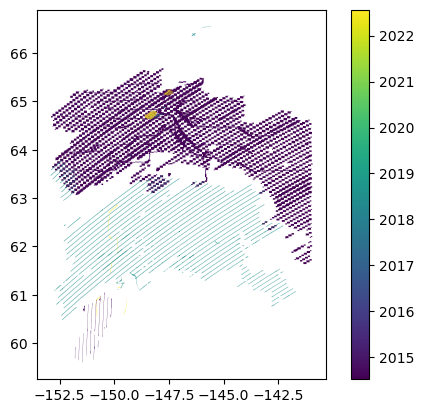

In [106]:
ax = gliht_ak.plot(column='decyear', legend=True)

## Load Global Maxar GDB

In [50]:
#maxar_all = gpd.read_file('/vsizip/'+maxar_gdb_fn, driver='FileGDB', layer=maxar_gdb_stereo_layer)

In [52]:
maxar_all.shape

(1486880, 20)

In [64]:
maxar_all.total_bounds

array([-179.9999    ,  -88.51320906,  183.58452028,   84.96595635])

### Read only AK (fails)

In [65]:
ak_bounds = [-179.9999, 51.219862, -129.6308406, 71.352561]

In [66]:
maxar_ak = gpd.read_file('/vsizip/'+maxar_gdb_fn, driver='FileGDB', layer=layer, bbox=ak_bounds)

In [67]:
maxar_ak.shape

(0, 20)

### Load clipped Maxar AK gpkg

In [89]:
#See the new `mask` functionality for `read_file`, followed by clip to remove polygons across the dateline
maxar_ak = gpd.read_file(maxar_fn_all, mask=ak_geom).cx[-180:0, -90:90]

In [179]:
maxar_ak['acqdate'] = pd.to_datetime(maxar_ak['acqdate'])

In [59]:
maxar_ak.total_bounds

array([-179.3278267 ,   51.10094794, -129.6308406 ,   71.529912  ])

In [90]:
maxar_ak.shape

(15029, 20)

<AxesSubplot:>

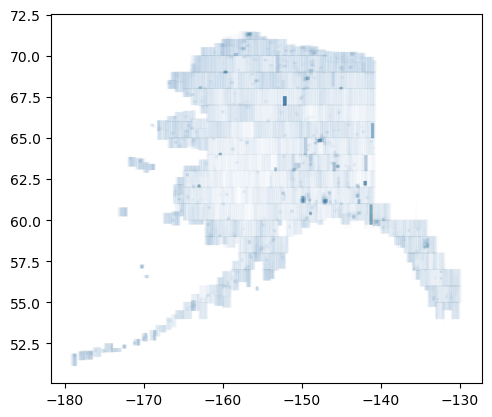

In [18]:
maxar_ak.plot(alpha=0.01);

### Load MAXAR conus

In [116]:
maxar_conus = gpd.read_file(maxar_fn_conus)

In [117]:
maxar_conus.shape

(11074, 20)

## Load 3DEP index for conus (WESM)

In [136]:
wesm = gpd.read_file(wesm_fn)

In [137]:
wesm.shape

(2750, 27)

In [138]:
#Get rid of problematic Lake Powell record with start of 1947
wesm.drop(0, inplace=True)

In [139]:
wesm.columns

Index(['workunit', 'workunit_id', 'project', 'project_id', 'collect_start',
       'collect_end', 'ql', 'spec', 'p_method', 'dem_gsd_meters', 'horiz_crs',
       'vert_crs', 'geoid', 'lpc_pub_date', 'lpc_category', 'lpc_reason',
       'sourcedem_pub_date', 'sourcedem_category', 'sourcedem_reason',
       'onemeter_category', 'onemeter_reason', 'seamless_category',
       'seamless_reason', 'lpc_link', 'sourcedem_link', 'metadata_link',
       'geometry'],
      dtype='object')

In [140]:
wesm['collect_start'] = pd.to_datetime(wesm['collect_start'])
wesm['collect_end'] = pd.to_datetime(wesm['collect_end'])
wesm['collect_duration'] = wesm['collect_end'] - wesm['collect_start']
wesm['collect_duration_days'] = wesm['collect_duration'].dt.total_seconds()/86400

In [141]:
wesm['collect_start_decyear'] = wesm['collect_start'].apply(toYearFraction)
wesm['collect_end_decyear'] = wesm['collect_end'].apply(toYearFraction)

In [163]:
maxar_chull_geom = maxar_conus.unary_union.convex_hull

In [164]:
wesm_idx = wesm.intersects(maxar_chull_geom)

In [143]:
wesm = wesm[wesm_idx]

In [144]:
wesm.shape

(586, 31)

In [145]:
#wesm_simple = wesm.simplify(0.1)

<AxesSubplot:>

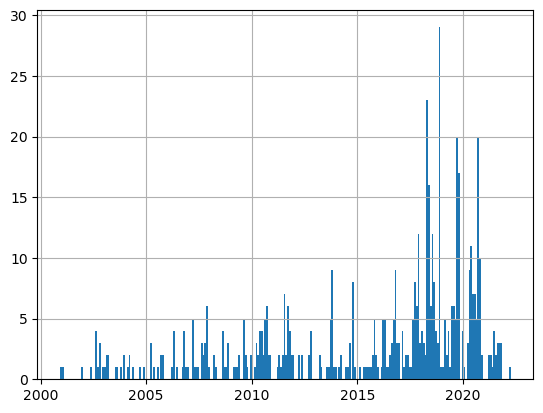

In [151]:
wesm['collect_start_decyear'].hist(bins=256)

<AxesSubplot:>

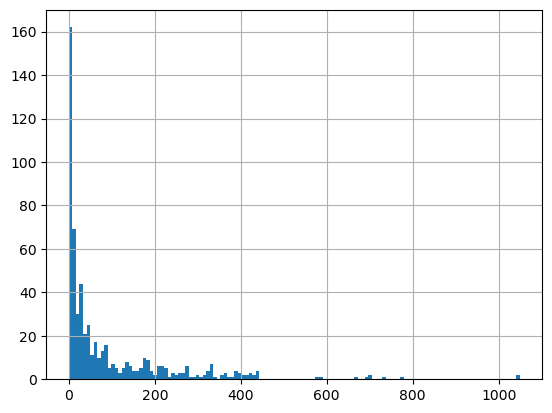

In [120]:
wesm['collect_duration_days'].hist(bins=128)

<AxesSubplot:>

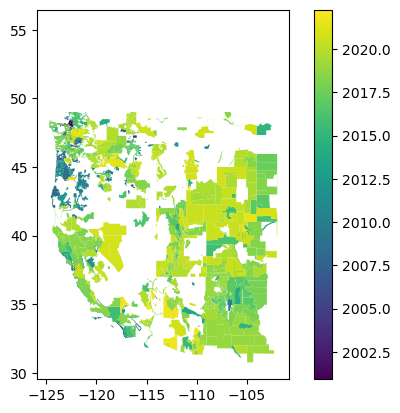

In [146]:
wesm.plot(column='collect_start_decyear', legend=True)

### Use feature envelope for first spatial filter

In [147]:
wesm_orig = wesm.copy()

In [148]:
wesm_env_geom = wesm.envelope

In [149]:
wesm['geometry'] = wesm_env_geom

<AxesSubplot:>

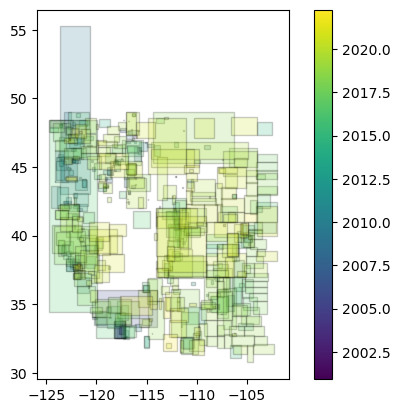

In [150]:
wesm.plot(column='collect_start_decyear', alpha=0.2, edgecolor='k', legend=True)

<AxesSubplot:>

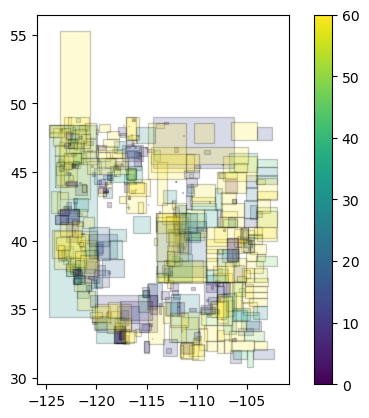

In [155]:
wesm.plot(column='collect_duration_days', alpha=0.2, edgecolor='k', legend=True, vmax=60)

In [157]:
#Reproject
wesm = wesm.to_crs(maxar_conus.crs)

In [158]:
maxar_conus['acqdate'] = pd.to_datetime(maxar_conus['acqdate'])

<AxesSubplot:>

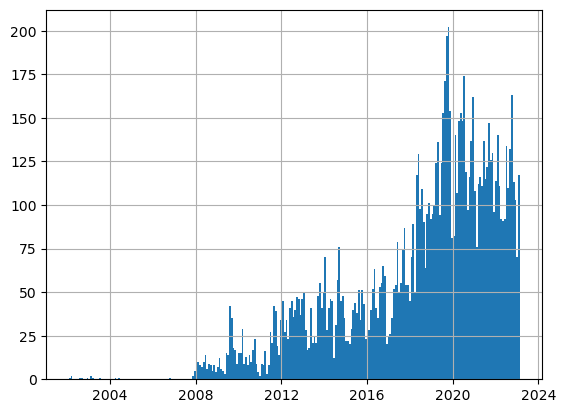

In [159]:
maxar_conus['acqdate'].hist(bins=256)

<AxesSubplot:>

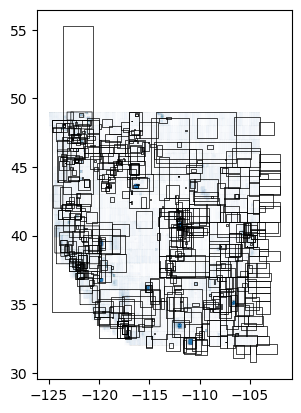

In [160]:
f, ax = plt.subplots()
maxar_conus.plot(ax=ax, edgecolor='k', lw=0.1, alpha=0.01)
wesm.plot(ax=ax, facecolor='none', lw=0.5)

## Load RGI polygons

In [184]:
rgi_fn_01 = 'zip+https://www.glims.org/RGI/rgi60_files/01_rgi60_Alaska.zip!01_rgi60_Alaska.shp'
rgi_fn_02 = 'zip+https://www.glims.org/RGI/rgi60_files/02_rgi60_WesternCanadaUS.zip!02_rgi60_WesternCanadaUS.shp'

In [165]:
rgi_gdf_conus = gpd.read_file(rgi_fn_02, mask=maxar_chull_geom)
rgi_gdf_conus_geom = rgi_gdf_conus.unary_union

In [185]:
rgi_gdf_ak = gpd.read_file(rgi_fn_01).cx[-180:0, -90:90]

In [187]:
rgi_gdf_ak.shape

(27108, 23)

In [186]:
rgi_gdf_ak_geom = rgi_gdf_ak.unary_union

In [217]:
#wesm_rgi = wesm.intersects(rgi_gdf_filt_geom)

## Spatiotemporal filter

In [167]:
pad = pd.Timedelta(days=1)

In [168]:
max_duration = pd.Timedelta(days=120)

In [169]:
wesm_short = wesm['collect_duration'] < max_duration

<AxesSubplot:>

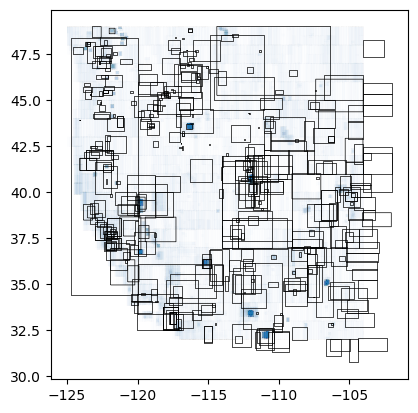

In [170]:
f, ax = plt.subplots()
maxar.plot(ax=ax, edgecolor='k', lw=0.1, alpha=0.01)
wesm[wesm_short].plot(ax=ax, facecolor='none', lw=0.5)

In [ ]:
st_search(wesm[wesm_short], maxar_conus, col1=

In [178]:
row[datecol1]

Timestamp('2014-07-10 00:00:00')

In [ ]:
def st_search(gdf1, gdf2, datecol1='datetime', datecol2='acqdate', bbox1=False, bbox2=False):
    hits = {}
    print(gdf1.shape[0])
    print(gdf2.shape[0])
    for i, row in gdf1.iterrows():
        spatial_idx = gdf2.intersects(row.geometry)
        if spatial_idx.any():
            spatial_hits = gdf2[spatial_idx]
            temporal_idx = (spatial_hits[datecol2] >= row[datecol1] - pad) & (spatial_hits[datecol2] <= row[datecol1] + pad)
            if temporal_idx.any():
                hits[i] = spatial_hits[temporal_idx]
                print(i, row['workunit'], row['collect_start'].date(), row['collect_end'].date(), row['collect_duration'].days, \
                      temporal_hits[spatial_idx_fine]['acqdate'].dt.strftime('%Y-%m-%d').values)

In [181]:
i

2790

In [182]:
row

Name                                                    l10s655
Descriptio                                                 None
file                                          AK_20140807_tiles
geometry      POLYGON ((-151.80306 64.015843, -151.77854 64....
datetime                                    2014-08-07 00:00:00
decyear                                             2014.597146
Name: 2790, dtype: object

In [183]:
hits = {}

datecol1='datetime'
datecol2='acqdate'

for i, row in gliht_ak.iterrows():
    spatial_idx = maxar_ak.intersects(row.geometry)
    if spatial_idx.any():
        spatial_hits = maxar_ak[spatial_idx]
        temporal_idx = (spatial_hits[datecol2] >= row[datecol1] - pad) & (spatial_hits[datecol2] <= row[datecol1] + pad)
        if temporal_idx.any():
            hits[i] = spatial_hits[temporal_idx]
            print(i, row, spatial_hits[temporal_idx][datecol2].dt.strftime('%Y-%m-%d').values)

2790 Name                                                    l10s655
Descriptio                                                 None
file                                          AK_20140807_tiles
geometry      POLYGON ((-151.80306 64.015843, -151.77854 64....
datetime                                    2014-08-07 00:00:00
decyear                                             2014.597146
Name: 2790, dtype: object ['2014-08-08']
2833 Name                                                     l24s35
Descriptio                                                 None
file                                          AK_20140807_tiles
geometry      POLYGON ((-151.82585 64.000798, -151.81398 64....
datetime                                    2014-08-07 00:00:00
decyear                                             2014.597146
Name: 2833, dtype: object ['2014-08-08']
2911 Name                                                     l6s618
Descriptio                                                 None
file   

In [188]:
gliht_ak_hits = gliht_ak.loc[hits.keys()]

In [189]:
maxar_ak_hits = pd.concat(hits.values())

<AxesSubplot:>

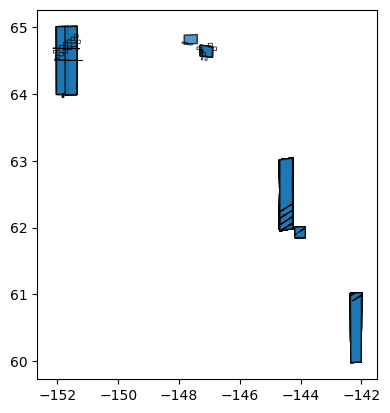

In [193]:
f, ax = plt.subplots()
maxar_ak_hits.plot(ax=ax, edgecolor='k', alpha=0.5)
gliht_ak_hits.plot(ax=ax, facecolor='none', lw=0.5)
#ctx.add_basemap(ax=ax, crs=maxar_ak_hits.crs, source=ctx.providers.Stamen.Terrain, alpha=0.5)

In [174]:
hits = {}

for i, row in wesm[wesm_short].iterrows():
    spatial_idx = maxar_conus.intersects(row.geometry)
    if spatial_idx.any():
        spatial_hits = maxar_conus[spatial_idx]
        temporal_idx = (spatial_hits['acqdate'] >= row['collect_start'] - pad) & (spatial_hits['acqdate'] <= row['collect_end'] + pad)
        if temporal_idx.any():
            temporal_hits = spatial_hits[temporal_idx]
            #Do detailed spatial search with original polygon and RGI
            spatial_idx_fine = temporal_hits.intersects(wesm_orig.loc[i].geometry) & temporal_hits.intersects(rgi_gdf_conus_geom)
            if spatial_idx_fine.any():
                hits[i] = temporal_hits[spatial_idx_fine]
                print(i, row['workunit'], row['collect_start'].date(), row['collect_end'].date(), row['collect_duration'].days, \
                      temporal_hits[spatial_idx_fine]['acqdate'].dt.strftime('%Y-%m-%d').values)

494 CO_ARKANSASVALLEY_2010 2010-09-09 2010-10-28 49 ['2010-09-09']
1336 WA_MtBaker_2015 2015-08-26 2015-09-27 32 ['2015-09-11' '2015-09-28']
1526 WA_MountAdams_2016 2016-08-15 2016-09-26 42 ['2016-09-26']
2099 MT_NRCS_B1_QL2_2018 2018-07-03 2018-07-16 13 ['2018-07-12']
2415 WY_FEMA_East_B9_2019 2019-07-26 2019-09-22 58 ['2019-08-17' '2019-08-17' '2019-08-26']
2421 WY_FEMA_East_B7_2019 2019-08-05 2019-09-15 41 ['2019-09-07']
2429 CO_WestCentral_2019 2019-08-21 2019-09-19 29 ['2019-09-02' '2019-09-02']
2451 CA_YosemiteNP_2019 2019-10-07 2019-10-23 16 ['2019-10-06' '2019-10-08' '2019-10-14' '2019-10-14' '2019-10-19'
 '2019-10-21']
2454 CA_CarrHirzDeltaFires_2_2019 2019-10-11 2019-12-27 77 ['2019-10-18' '2019-11-11' '2019-11-12' '2019-11-20']
2607 MT_RavalliGraniteCusterPowder_4_2019 2020-05-09 2020-08-29 112 ['2020-07-11']
2619 CO_DRCOG_1_2020 2020-05-29 2020-08-03 66 ['2020-06-01' '2020-06-16' '2020-06-20' '2020-07-21']
2632 WY_Sheridan_2_2020 2020-07-19 2020-09-12 55 ['2020-08-14']
2635

In [229]:
wesm_hits = wesm_orig.loc[hits.keys()]

In [230]:
maxar_hits = pd.concat(hits.values())

In [231]:
import contextily as ctx

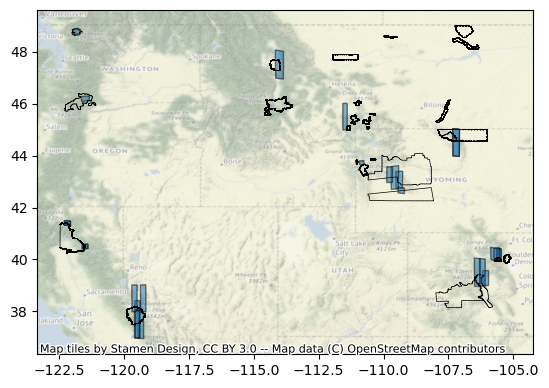

In [235]:
f, ax = plt.subplots()
maxar_hits.plot(ax=ax, edgecolor='k', alpha=0.5)
wesm_hits.plot(ax=ax, facecolor='none', lw=0.5)
ctx.add_basemap(ax=ax, crs=maxar_hits.crs, source=ctx.providers.Stamen.Terrain, alpha=0.5)

In [184]:
#Need to convert Timestamp back to str
#m = maxar_hits.explore()
#wesm_hits.explore(m=m)

In [264]:
#pd.set_option('display.max_colwidth', None)

In [265]:
wesm_hits['metadata_link']

494                                                   http://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/legacy/CO_ARKANSASVALLEY_2010
1336                                                http://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/WA_MtBaker_2015/WA_MtBaker_2015
1526                               http://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/WA_Mount_Adams_LiDAR_2016_D16/WA_MountAdams_2016
2099                                        http://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/MT_NRCS_MT_2018_D18/MT_NRCS_B1_QL2_2018
2415                                     http://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/WY_FEMA_East_2019_D19/WY_FEMA_East_B9_2019
2421                                     http://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/WY_FEMA_East_2019_D19/WY_FEMA_East_

In [256]:
flightline_url = wesm_hits.loc[1526]['metadata_link']+'/shapefiles/Mount_Adams_Flightline_Index.shp'

In [260]:
flightline_url

'http://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/WA_Mount_Adams_LiDAR_2016_D16/WA_MountAdams_2016/shapefiles/Mount_Adams_Flightline_Index.shp'

In [262]:
flightline_url_clean = flightline_url.replace('index.html?prefix=','')

In [ ]:
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/metadata/WA_Mount_Adams_LiDAR_2016_D16/WA_MountAdams_2016/shapefiles/Mount_Adams_Flightline_Index.shp

In [268]:
flightline_url_clean = 'http://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/metadata/CA_YosemiteNP_2019_D19/CA_YosemiteNP_2019/spatial_metadata/contractor_provided/Flightlines.gdb/'

In [ ]:
import fiona
fiona.listlayers(flightline_url_clean)

In [ ]:
gpd.read_file(flightline_url_clean)